## Setup

In [185]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg
from figures import plot_surplus, model_diffs, model_plot, plot_life_cycle

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

#plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})

# c++ settings
do_cpp = False
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Compile C++ files

In [45]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

Set model settings

In [224]:
# settings for models to solve
T = 3
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 1 old':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 2 old':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    # 'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 3 old':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
    # 'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 4 old':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads, 'old_bargaining':True}},
}


Solve models

In [225]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...
solving model 1 old...


## Compare bargaining solutions

'Model 1' is solved with the new bargaining algorithm. 'Model 1 old' is solved with the old algorithm. We plot the surplus functions and updating schemes for both models. We also print differences in solutions.

Compare speed of algorithms

In [226]:
# Set index
t=1
iP=10
iL=20
iA=10

idx_couple = lambda iP: (t,iP,iL,iA)
idx_single = (t,iA)

sol = models['model 1'].sol
par = models['model 1'].par

# Unpack lists
remain_Vw = sol.Vw_remain_couple[t,:,iL,iA]
remain_Vm = sol.Vm_remain_couple[t,:,iL,iA]
remain_Cw_priv = sol.Cw_priv_remain_couple[t,:,iL,iA]
remain_Cm_priv = sol.Cm_priv_remain_couple[t,:,iL,iA]
remain_C_pub = sol.C_pub_remain_couple[t,:,iL,iA]

list_couple = copy.deepcopy((sol.Vw_couple,sol.Vm_couple,sol.Cw_priv_couple,sol.Cm_priv_couple,sol.C_pub_couple))
list_raw = copy.deepcopy((remain_Vw,remain_Vm,remain_Cw_priv,remain_Cm_priv,remain_C_pub))
list_single = copy.deepcopy((sol.Vw_single,sol.Vm_single,sol.Cw_priv_single,sol.Cm_priv_single,sol.Cw_pub_single)) # last input here not important in case of divorce

# Get power variables
power_idx = copy.deepcopy(sol.power_idx)
power = copy.deepcopy(sol.power)

# Calculate surplus
Sw = sol.Vw_remain_couple[t,:,iL,iA]-sol.Vw_single[idx_single]
Sm = sol.Vm_remain_couple[t,:,iL,iA]-sol.Vm_single[idx_single]

In [229]:
# Time check_participation_constraints
%timeit  brg.check_participation_constraints(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

320 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [230]:
%timeit brg.check_participation_constraints_old2(power_idx,power,Sw,Sm,idx_single,idx_couple,list_couple,list_raw,list_single, par)

380 µs ± 49.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Calculate differences in solutions

In [231]:
def deviation(new,old):
    model_diff = model_diffs(new,old)
    for var in model_diff.sol.__dict__.keys():
        biggest_diff = np.max(np.abs(model_diff.sol.__dict__[var]))
        if biggest_diff == 0.0:
            print(f'Max % dev in {var:24}: {biggest_diff:.8%}')
        else:
            index_of_biggest_diff = np.where(np.abs(model_diff.sol.__dict__[var]) == biggest_diff)
            old_value = np.abs(old.sol.__dict__[var][index_of_biggest_diff][0])
            print(f'Max % dev in {var:24}: {biggest_diff/old_value:.8%}')

In [232]:
deviation(models['model 1'], models['model 1 old'])

Max % dev in Vw_single               : 0.00000000%
Max % dev in Vm_single               : 0.00000000%
Max % dev in Cw_priv_single          : 0.00000000%
Max % dev in Cm_priv_single          : 0.00000000%
Max % dev in Cw_pub_single           : 0.00000000%
Max % dev in Cm_pub_single           : 0.00000000%
Max % dev in Cw_tot_single           : 0.00000000%
Max % dev in Cm_tot_single           : 0.00000000%
Max % dev in Vw_trans_single         : 0.00000000%
Max % dev in Vm_trans_single         : 0.00000000%
Max % dev in Cw_priv_trans_single    : 0.00000000%
Max % dev in Cm_priv_trans_single    : 0.00000000%
Max % dev in Cw_pub_trans_single     : 0.00000000%
Max % dev in Cm_pub_trans_single     : 0.00000000%
Max % dev in Cw_tot_trans_single     : 0.00000000%
Max % dev in Cm_tot_trans_single     : 0.00000000%
Max % dev in Vw_couple               : 0.00000000%
Max % dev in Vm_couple               : 0.00000000%
Max % dev in Cw_priv_couple          : 0.00000000%
Max % dev in Cm_priv_couple    

In [234]:
deviation(models['model 2'], models['model 2 old'])


KeyError: 'model 2'

In [58]:
model_diff = model_diffs(models['model 2'], models['model 2 old'])
for var in model_diff.sol.__dict__.keys():
    print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


Max diff in Vw_single               : 0.00000000
Max diff in Vm_single               : 0.00000000
Max diff in Cw_priv_single          : 0.00000000
Max diff in Cm_priv_single          : 0.00000000
Max diff in Cw_pub_single           : 0.00000000
Max diff in Cm_pub_single           : 0.00000000
Max diff in Cw_tot_single           : 0.00000000
Max diff in Cm_tot_single           : 0.00000000
Max diff in Vw_trans_single         : 0.00000000
Max diff in Vm_trans_single         : 0.00000000
Max diff in Cw_priv_trans_single    : 0.00000000
Max diff in Cm_priv_trans_single    : 0.00000000
Max diff in Cw_pub_trans_single     : 0.00000000
Max diff in Cm_pub_trans_single     : 0.00000000
Max diff in Cw_tot_trans_single     : 0.00000000
Max diff in Cm_tot_trans_single     : 0.00000000
Max diff in Vw_couple               : 2.18092836
Max diff in Vm_couple               : 2.18092826
Max diff in Cw_priv_couple          : 0.16283053
Max diff in Cm_priv_couple          : 0.16705659
Max diff in C_pub_co

In [59]:
model_diff = model_diffs(models['model 3'], models['model 3 old'])
for var in model_diff.sol.__dict__.keys():
    print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


Max diff in Vw_single               : 0.00000000
Max diff in Vm_single               : 0.00000000
Max diff in Cw_priv_single          : 0.00000000
Max diff in Cm_priv_single          : 0.00000000
Max diff in Cw_pub_single           : 0.00000000
Max diff in Cm_pub_single           : 0.00000000
Max diff in Cw_tot_single           : 0.00000000
Max diff in Cm_tot_single           : 0.00000000
Max diff in Vw_trans_single         : 0.00000000
Max diff in Vm_trans_single         : 0.00000000
Max diff in Cw_priv_trans_single    : 0.00000000
Max diff in Cm_priv_trans_single    : 0.00000000
Max diff in Cw_pub_trans_single     : 0.00000000
Max diff in Cm_pub_trans_single     : 0.00000000
Max diff in Cw_tot_trans_single     : 0.00000000
Max diff in Cm_tot_trans_single     : 0.00000000
Max diff in Vw_couple               : 1.67789492
Max diff in Vm_couple               : 1.67792621
Max diff in Cw_priv_couple          : 0.45527674
Max diff in Cm_priv_couple          : 0.43923064
Max diff in C_pub_co

In [60]:
model_diff = model_diffs(models['model 4'], models['model 4 old'])
for var in model_diff.sol.__dict__.keys():
    print(f'Max diff in {var:24}: {np.max(np.abs(model_diff.sol.__dict__[var])):.8f}')


Max diff in Vw_single               : 0.00000000
Max diff in Vm_single               : 0.00000000
Max diff in Cw_priv_single          : 0.00000000
Max diff in Cm_priv_single          : 0.00000000
Max diff in Cw_pub_single           : 0.00000000
Max diff in Cm_pub_single           : 0.00000000
Max diff in Cw_tot_single           : 0.00000000
Max diff in Cm_tot_single           : 0.00000000
Max diff in Vw_trans_single         : 0.00000000
Max diff in Vm_trans_single         : 0.00000000
Max diff in Cw_priv_trans_single    : 0.00000000
Max diff in Cm_priv_trans_single    : 0.00000000
Max diff in Cw_pub_trans_single     : 0.00000000
Max diff in Cm_pub_trans_single     : 0.00000000
Max diff in Cw_tot_trans_single     : 0.00000000
Max diff in Cm_tot_trans_single     : 0.00000000
Max diff in Vw_couple               : 2.71024479
Max diff in Vm_couple               : 2.57099400
Max diff in Cw_priv_couple          : 0.35039968
Max diff in Cm_priv_couple          : 0.34100110
Max diff in C_pub_co

Plot surplus functions

In [235]:
# Set index
t=6
iP=5
iL=20
iA=10

# Set subtitles
subtitles = [name.capitalize() for name in models.keys()]

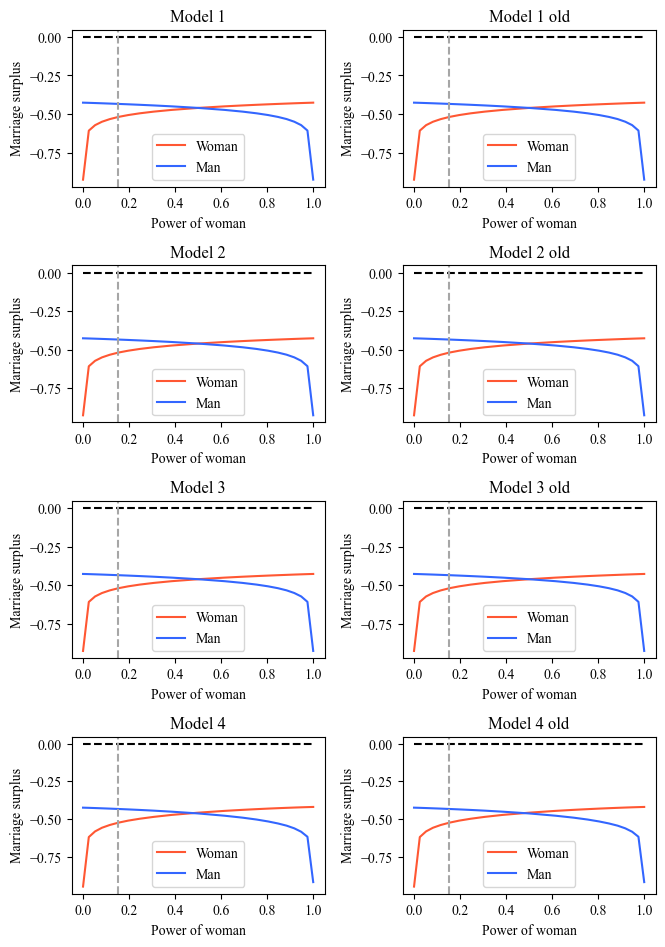

In [51]:
iL=10
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

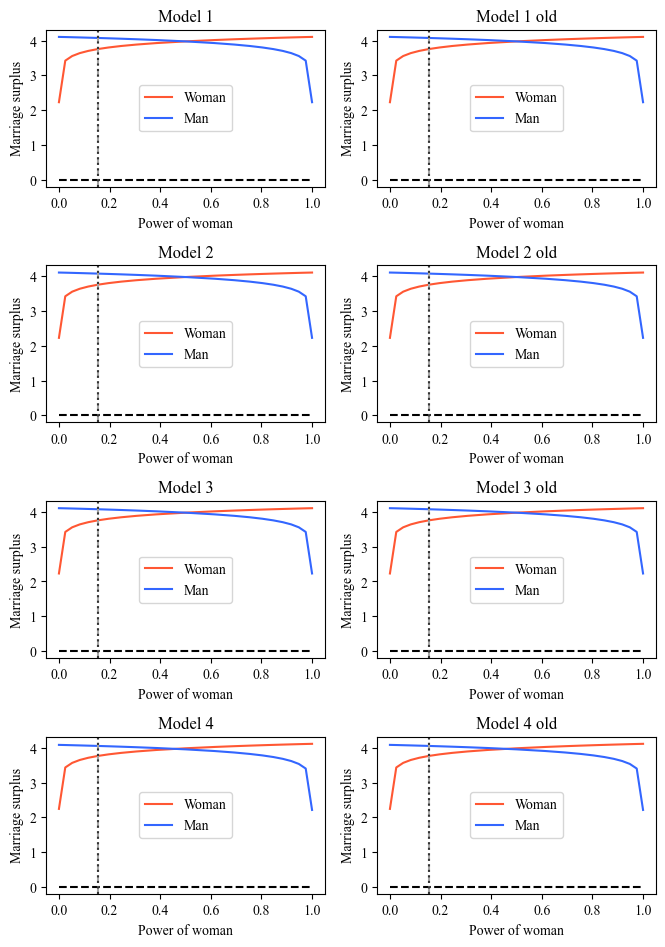

In [52]:
iL=40
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

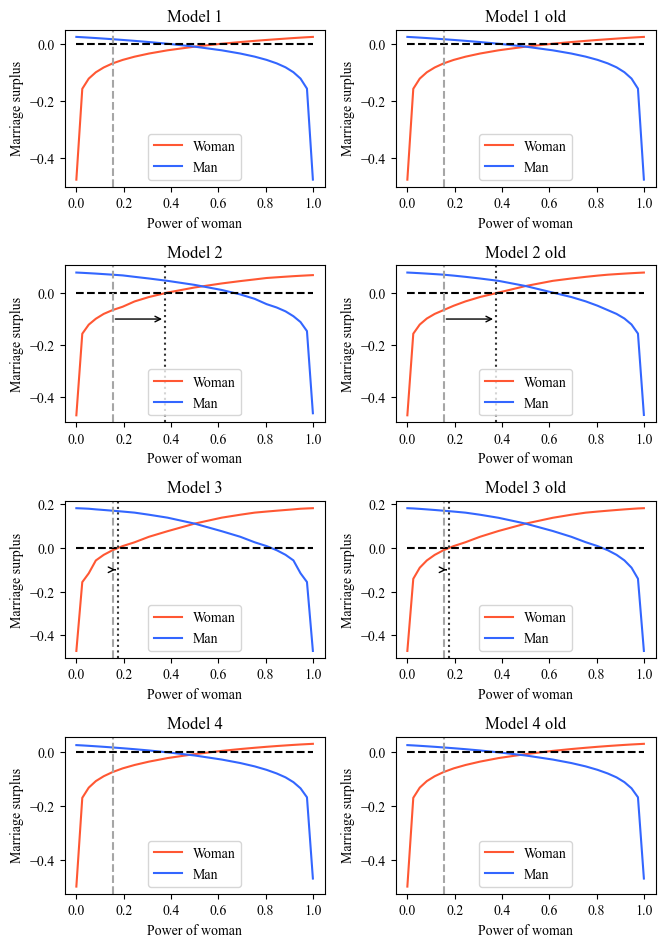

In [53]:
iL=19
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

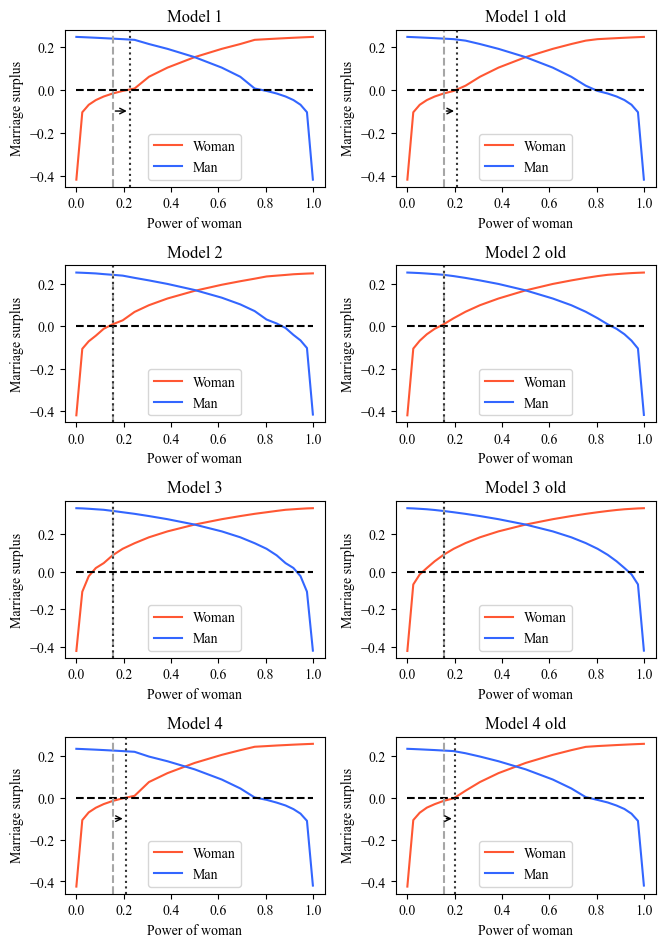

In [54]:
iL=20
iP=5
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

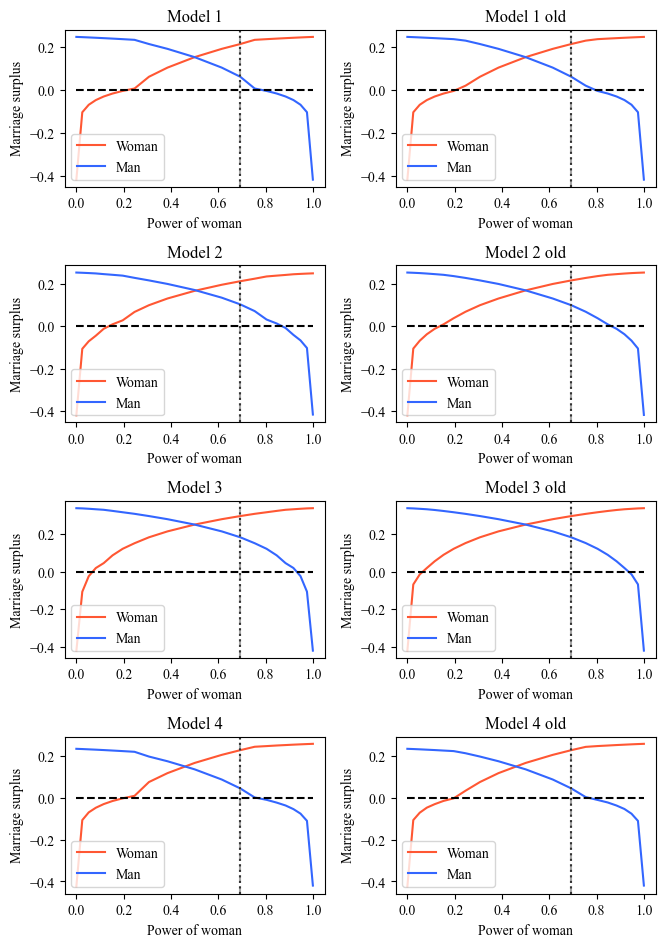

In [55]:
iL=20
iP=12
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

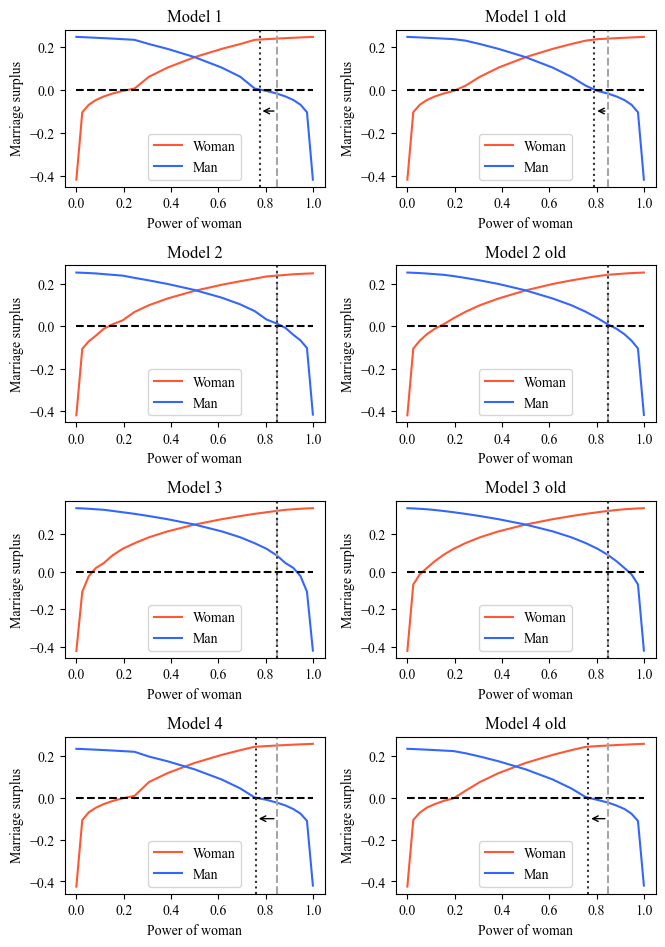

In [56]:
iL=20
iP=15
model_plot(models, plot_surplus, t, iP, iL, iA, subtitles=subtitles)

Display time taken to solve models

In [236]:
for i in range(1,2):
    model_name = f'model {i}'
    new_algorithm = models[model_name].sol.solution_time[0]
    old_algorithm = models[f'{model_name} old'].sol.solution_time[0]

    print(model_name.capitalize())
    print(f"New algorithm took {new_algorithm:.2f} seconds")
    print(f"Old algorithm took {old_algorithm:.2f} seconds")
    print(f"New algorithm is {old_algorithm - new_algorithm:.2f} seconds faster")
    print(f"Which is a {-100*(new_algorithm - old_algorithm)/old_algorithm:.2f}% improvement")
    print('')

Model 1
New algorithm took 150.69 seconds
Old algorithm took 141.83 seconds
New algorithm is -8.85 seconds faster
Which is a -6.24% improvement



# Investigate deviations in solutions

In [ ]:
new = models['model 1']
old = models['model 1 old']
var = 'Vm_couple'
t=9

model_diff = model_diffs(new,old)
biggest_diff = np.max(np.abs(model_diff.sol.__dict__[var][t]))
index_of_biggest_diff = np.where(np.abs(model_diff.sol.__dict__[var]) == biggest_diff)
new_value = np.abs(new.sol.__dict__[var][index_of_biggest_diff][0])
old_value = np.abs(old.sol.__dict__[var][index_of_biggest_diff][0])
print(f'New value: {new_value:.8f}, Old value: {old_value:.8f}')
print(f'Max % dev in {var}: {biggest_diff/old_value:.8%}')

t, iP, iL, iA = index_of_biggest_diff
t = t[0]
iP = iP[0]
iL = iL[0]
iA = iA[0]
idx = (t,iP,iL,iA)
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

New value: 0.54230244, Old value: 0.24368795
Max % dev in Vm_couple: 122.53970352%
t = 9, iP = 19, iL = 28, iA = 9


In [ ]:
# Calculate surplus
Sw_new = new.sol.Vw_remain_couple[t,:,iL,iA]-new.sol.Vw_single[t,iA]
Sw_old = old.sol.Vw_remain_couple[t,:,iL,iA]-old.sol.Vw_single[t,iA]
Sm_new = new.sol.Vm_remain_couple[t,:,iL,iA]-new.sol.Vm_single[t,iA]
Sm_old = old.sol.Vm_remain_couple[t,:,iL,iA]-old.sol.Vm_single[t,iA]
woman = 1
man = 2

# calculate indifference points
Low_w_new, power_at_zero_w_new = brg.find_indifference_point(Sw_new,par, woman)
Low_w_old, power_at_zero_w_old = brg.find_indifference_point(Sw_old,par, woman)
Low_m_new, power_at_zero_m_new = brg.find_indifference_point(Sm_new,par, man)
Low_m_old, power_at_zero_m_old = brg.find_indifference_point(Sm_old,par, man)

print(f'woman indifference point (new / old):  {power_at_zero_w_new:.4f} / {power_at_zero_w_old:.4f}')
print(f'man indifference point (new / old)  :  {power_at_zero_m_new:.4f} / {power_at_zero_m_old:.4f}')
print(f'woman indifference index (new / old):  {Low_w_new} / {Low_w_old}')
print(f'man indifference index (new / old)  :  {Low_m_new} / {Low_m_old}')

woman indifference point (new / old):  0.0002 / 0.0002
man indifference point (new / old)  :  0.9998 / 0.9998
woman indifference index (new / old):  0 / 0
man indifference index (new / old)  :  19 / 19


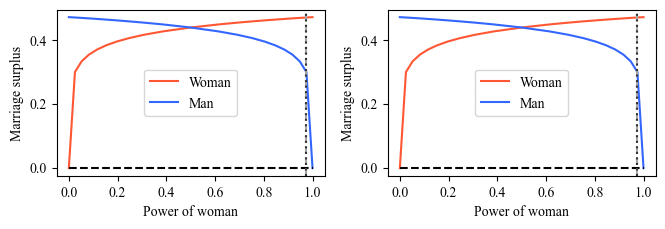

In [ ]:
model_plot([new,old],plot_surplus,t,iP,iL,iA)